In [1]:
import block_methods as BM

from Lanczos_FA.lanczos_bin import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import integrate
plt.rcParams["figure.figsize"] = (16,9)

In [2]:
n = 1000
w = 0
step = 2
K = 200
lam = np.linspace(1e-2,1e2,n)
b = np.ones(n,dtype=np.longdouble)
b /= np.linalg.norm(b)

In [3]:
def Gamma(t):
    radius = lmax_ - lmin_/100

    z = radius*np.exp(1j*t)+lmax_
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

def f(x):
    return np.sqrt(x)

In [4]:
def get_a_posteriori_bound(f,gamma,endpts,a_,b_,w,lmin,lmax):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    
    theta = sp.linalg.eigvalsh_tridiagonal(a_,b_,tol=1e-30)

    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.abs(np.prod((theta-w)/(theta-z))) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

# this deals with h_wz
def Q_wz(w,z,lmin,lmax):
    """
    max_{x\in[lmin,lmax]} |x-w|/|z-w|
    """
    
    if np.real(z) - w != 0:
        b_hat = ( np.abs(z)**2 - np.real(z)*w ) / (np.real(z) - w)
    else:
        b_hat = np.inf
    
    if lmin < b_hat <= lmax:
        return np.abs((z-w)/np.imag(z))
    else:
        return np.max([np.abs((lmax-w)/(lmax-z)), np.abs((lmin-w)/(lmin-z))])

In [5]:
def get_cwinvcz(Eval, Evec, z, w, itr, b, B_0):
    Dzinv = np.diag(1/(Eval-z))
    Dwinv = np.diag(1/(Eval-w))
        
    if b == 1:
        Cz = Evec@Dzinv@Evec.T@BM.Ei(itr*b, b, 1)*B_0
        Cwinv = np.linalg.solve(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)*B_0, -BM.Ei(itr*b, b, itr).T)
    else:
        Cz = Evec@Dzinv@Evec.T@BM.Ei(itr*b, b, 1)@B_0
        Cwinv = np.linalg.solve(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)@B_0, -BM.Ei(itr*b, b, itr).T)
    
    return Cwinv@Cz


def block_a_posteriori_bound(f,gamma,endpts,a_,b_,w,lmin,lmax, itr, b, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
#     make T matrix
    T = np.diag(a_.astype(np.double)) + np.diag(b_.astype(np.double), 1) + np.diag(b_.astype(np.double), -1)
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.linalg.norm(get_cwinvcz(Eval, Evec, z, w, itr, b, B_0)) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

In [6]:
def comparison(w, z, a_, b_, itr, B_0):
    T = np.diag(a_.astype(np.double)) + np.diag(b_.astype(np.double), 1) + np.diag(b_.astype(np.double), -1)
    Eval, Evec = np.linalg.eigh(T)
    
    theta = sp.linalg.eigvalsh_tridiagonal(a_,b_,tol=1e-30)
    
    return (np.abs(np.linalg.norm(get_cwinvcz(Eval, Evec, z, w, itr, 1, B_0)) - np.abs(np.prod((theta-w)/(theta-z)))), np.linalg.norm(get_cwinvcz(Eval, Evec, z, w, itr, 1, B_0)))

In [7]:
lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

lmin_ = lmin/2
lmax_ = 2*lmax

# norm to measure function approximation and linear system errors
B = lam

reorth=True

A = np.diag(lam.astype(np.longdouble))
Q,(a_,b_) = exact_lanczos(lam.astype(np.longdouble),b.astype(np.longdouble),K+1,reorth=reorth)

e1 = np.zeros(K+1)
e1[0] = 1

In [8]:
term_error = np.full(K,np.inf)
term = np.full(K,np.inf)
block_bound = np.full(K,np.inf)
old_bound = np.full(K,np.inf)


for k in range(1,int((K+1)/step)):
    B_0 = 1
    k = step*k
    term_error[int((k-1)/step)] = comparison(w, 1, a_[:k], b_[:k-1], k, B_0)[0]
    term[int((k-1)/step)] = comparison(w, 1, a_[:k], b_[:k-1], k, B_0)[1]
    block_bound[int((k-1)/step)] = block_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_, k, 1, B_0)[0]
    old_bound[int((k-1)/step)] = get_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_)[0]

C:\Users\qcx\AppData\Local\Temp\ipykernel_7008\3993440139.py:27: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)
C:\Users\qcx\AppData\Local\Temp\ipykernel_7008\3993440139.py:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)


C:\Users\qcx\AppData\Local\Temp\ipykernel_7008\2915685494.py:4: RuntimeWarning: invalid value encountered in subtract
  plt.plot(x*step, np.abs(block_bound-old_bound), label = "Total absolute difference")
C:\Users\qcx\AppData\Local\Temp\ipykernel_7008\2915685494.py:5: RuntimeWarning: invalid value encountered in subtract
  plt.plot(x*step, np.abs(block_bound-old_bound)/block_bound, label = "Total relative difference")
C:\Users\qcx\AppData\Local\Temp\ipykernel_7008\2915685494.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x*step, term_error/term, label = "New term relative difference")


<function matplotlib.pyplot.show(close=None, block=None)>

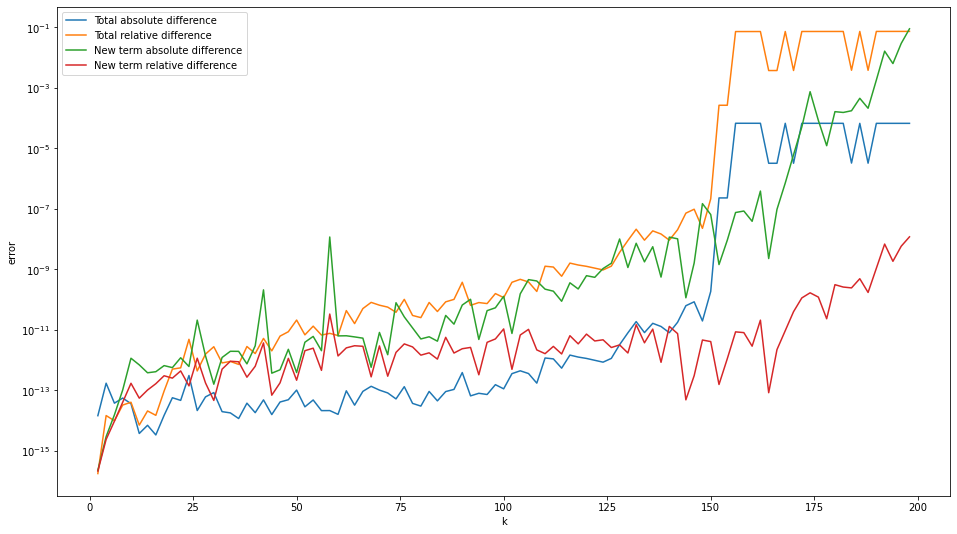

In [9]:
x = np.linspace(1, K, 200)
# plt.plot(x, a_posteriori_bound_circle_approx_spectrum, c='red')
# plt.plot(x, compare, c='green')
plt.plot(x*step, np.abs(block_bound-old_bound), label = "Total absolute difference")
plt.plot(x*step, np.abs(block_bound-old_bound)/block_bound, label = "Total relative difference")
plt.plot(x*step, term_error, label = "New term absolute difference")
plt.plot(x*step, term_error/term, label = "New term relative difference")
plt.yscale('log')
plt.xlabel("k")
plt.ylabel("error")
plt.legend()
plt.show

In [10]:
def block_a_posteriori_bound_mid(f, gamma, endpts, a_, b_, Q, A, b, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
#     make T matrix
    
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.linalg.norm(f(z)* exact_err(z, A, b, Q, T, B_0)) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

In [11]:
def block_a_posteriori_bound_exact(f, H, V, Q, a_, b_, B_0, b):
# This integrand is a vector.SP seems to be not happy about that, so compute with the first line (f(H).....) instead
    EvalH, EvecH = np.linalg.eigh(H)
    fEvalH = f(EvalH)
    fH = EvecH@np.diag(fEvalH)@EvecH.conj().T
    
    T = np.diag(a_.astype(np.double)) + np.diag(b_.astype(np.double), 1) + np.diag(b_.astype(np.double), -1)
    EvalT, EvecT = np.linalg.eigh(T)
    fEvalT = f(EvalT)
    fT = EvecT@np.diag(fEvalT)@EvecT.conj().T
    
    if b == 1:
        return np.linalg.norm(fH@V-(Q@fT)[:, 0]*B_0)
    
    return np.linalg.norm(fH@V-(Q@fT)[:, 0]@B_0)

In [12]:
# use linear solver as oppose to get inverse
def exact_err(z, H, V, Q, T, B_0):
    Hinv = 1/(np.diag(H)-z)
    HinvV = Hinv*V
    
#     HinvV = np.linalg.solve((H-z*np.eye(H.shape[0])), V)
    E1 = BM.Ei(np.shape(T)[0], 1, 1)
    E1_array = np.reshape(E1, len(E1))
    TinvE = np.linalg.solve((T-z*np.eye(T.shape[0])), E1_array)

    return HinvV - Q@TinvE*B_0

In [13]:
block_mid = np.full(K,np.inf)
block_exact = np.full(K,np.inf)

for k in range(1,int((K+1)/step)):
    k = step*k
    B_0 = 1
    block_mid[int((k-1)/step)] = block_a_posteriori_bound_mid(f,Gamma,[0,np.pi],a_[:k],b_[:k-1], Q[:, :k], A, b.astype(np.double), B_0)[0]
    block_exact[int((k-1)/step)] = block_a_posteriori_bound_exact(f,A.astype(np.double), b.astype(np.double),Q[:, :k],a_[:k],b_[:k-1], B_0, 1)

C:\Users\qcx\AppData\Local\Temp\ipykernel_7008\162586358.py:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)


In [14]:
full_block_bound = np.full(K,np.inf)

T = np.diag(a_.astype(np.double)) + np.diag(b_.astype(np.double), 1) + np.diag(b_.astype(np.double), -1)
for k in range(1,int((K+1)/step)):
    k = step*k
    full_block_bound[int((k-1)/step)] = block_bound[int((k-1)/step)]*np.linalg.norm(exact_err(w, A, b, Q[:, :k], T[:k, :k], 1))

<function matplotlib.pyplot.show(close=None, block=None)>

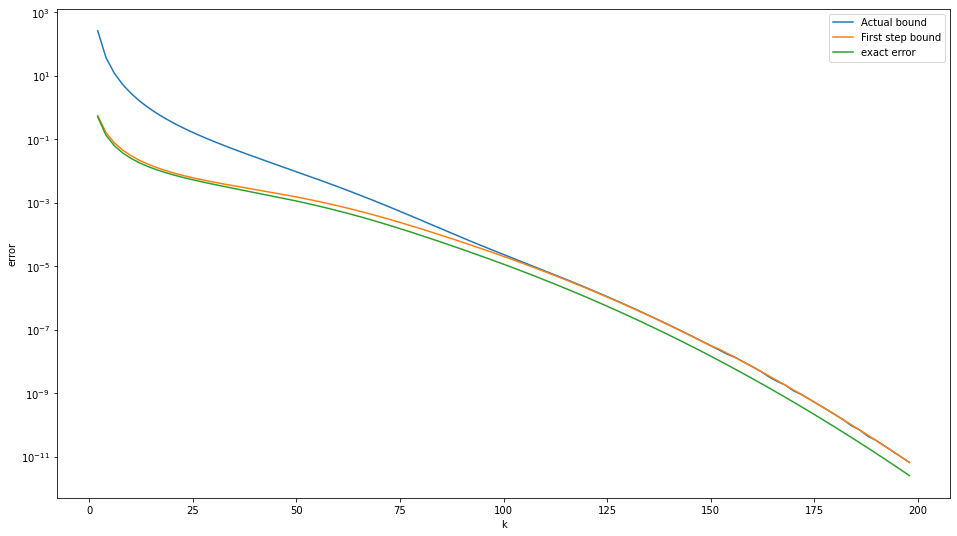

In [15]:
x = np.linspace(1, K, 200)

plt.plot(x*step, np.abs(full_block_bound), label = "Actual bound")
plt.plot(x*step, np.abs(block_mid), label = "First step bound")
plt.plot(x*step, np.abs(block_exact), label = "exact error")


plt.yscale('log')
plt.xlabel("k")
plt.ylabel("error")
plt.legend()
plt.show